In [160]:
import nltk
import pandas as pd
import numpy as np
import matplotlib
import random 
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import pickle

In [161]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()
    print(data_frame[class_name].value_counts())


In [162]:
# inputFile="../data/labeled/labeled_dataV1.csv"
# df = pd.read_csv(inputFile)

df= pd.DataFrame()
dbfile = open('../data/labeled/labeled_dataV3', 'rb')      
df= pickle.load(dbfile) 
dbfile.close() 
#df=df[1:500000] 


#df['all_text']= df['all_tokens'].apply(lambda x: " ".join(x))
# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
 

labeled_data=df[df['class']!= '-1'].copy()

#encode the classes to their index 
labeled_data['labels']=labeled_data['class'].apply( classes.index)
print(classes)

print(df.shape)

['unisex', 'men', 'women', 'kid', 'baby']
(500000, 18)


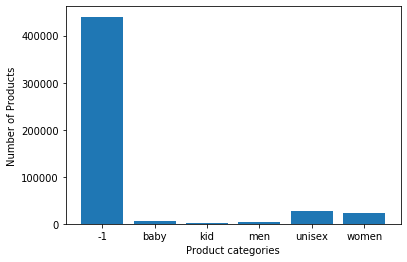

-1        440271
unisex     26806
women      22146
baby        6048
men         4061
kid          668
Name: class, dtype: int64


In [163]:
plot_class_distribution (df, 'product_type','class', starting_index=0)

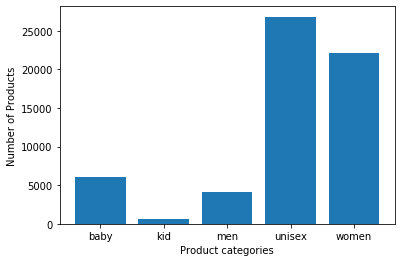

-1        440271
unisex     26806
women      22146
baby        6048
men         4061
kid          668
Name: class, dtype: int64


In [164]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

### Remove unnecessary columns

In [165]:
#get rid 
#df.drop(labels=['description', 'unisex', 'men', 'women', 'baby', 'kid', 'store_product_brand_domain'], axis=1)
#df.loc[:, ['product_type','full_store_product_url','all_tokens','all_text','all_text_original','primary_price' ]]

# Bag of Words Counts 

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = labeled_data["all_text"].tolist()
list_labels = labeled_data["labels"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, 
                                                    list_labels, test_size=0.2,
                                                     random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#size of our features
X_train_counts.shape

(47783, 132537)

## Visualizing the embeddings
Since visualizing data in large dimensions is hard, let's project it down to 2.

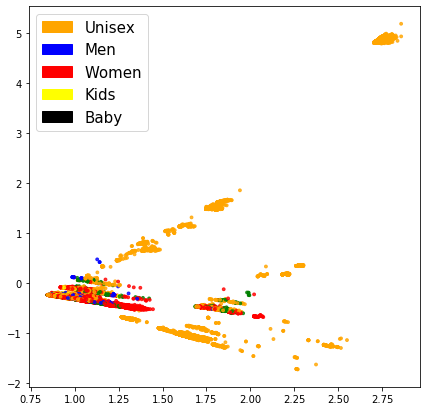

In [167]:


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red', 'yellow', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Unisex')
            blue_patch = mpatches.Patch(color='blue', label='Men')
            red_patch = mpatches.Patch(color='red', label='Women')
            yellow_patch = mpatches.Patch(color='yellow', label='Kids')
            green_patch = mpatches.Patch(color='black', label='Baby')
            plt.legend(handles=[orange_patch, blue_patch, red_patch,yellow_patch, green_patch], prop={'size': 15})


fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [168]:
#display(df.head())
#display(labeled_data.head())

print(df.shape)
print(labeled_data.shape)

(500000, 18)
(59729, 19)


## Fitting logistic regression


In [169]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Evaluation

In [170]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.999, precision = 0.999, recall = 0.999, f1 = 0.999


In [171]:
y_predicted_counts

array([0, 0, 2, ..., 0, 1, 2])

## Let's see how confident is our classifier 

In [194]:
def cal_probability(X_test):
    allRecords_probabilty=clf.predict_proba(X_test)
    allRecords_max_probabilty = []
    for i in range(0, allRecords_probabilty.shape[0]):
        probablities=allRecords_probabilty[i]
        prob_index= np.argmax(probablities)
        prob_max= max(probablities)
        allRecords_max_probabilty.append(prob_max)
    
    fig = plt.figure(figsize=(5, 5)) 
    plt.xlabel('Prediction Probability')
    plt.ylabel('Number of records')
    plt.hist(allRecords_max_probabilty)
    plt.show()
    return allRecords_max_probabilty 


    


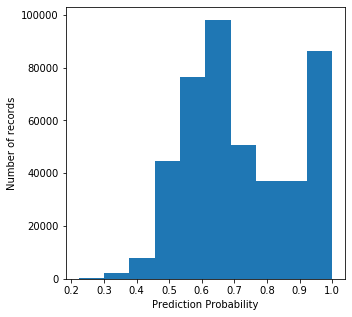

In [196]:
_=cal_probability(X_test_counts)




## Inspection
 Let's start by looking at the confusion matrix.

In [174]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=15)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

    return plt

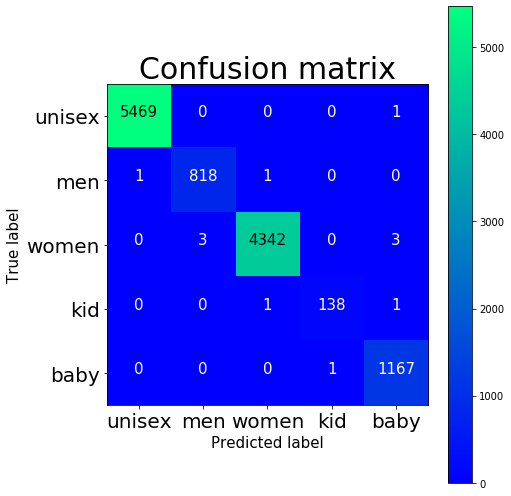

[[5469    0    0    0    1]
 [   1  818    1    0    0]
 [   0    3 4342    0    3]
 [   0    0    1  138    1]
 [   0    0    0    1 1167]]


In [175]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix')
plt.show()
print(cm)

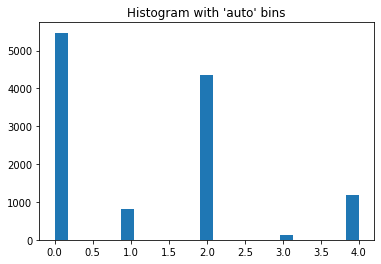

In [176]:

_=plt.hist(y_predicted_counts, bins='auto')
plt.title("Histogram with 'auto' bins")
plt.show()

## Further inspection
Let's look at the features our classifier is using to make decisions.

In [177]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 15)


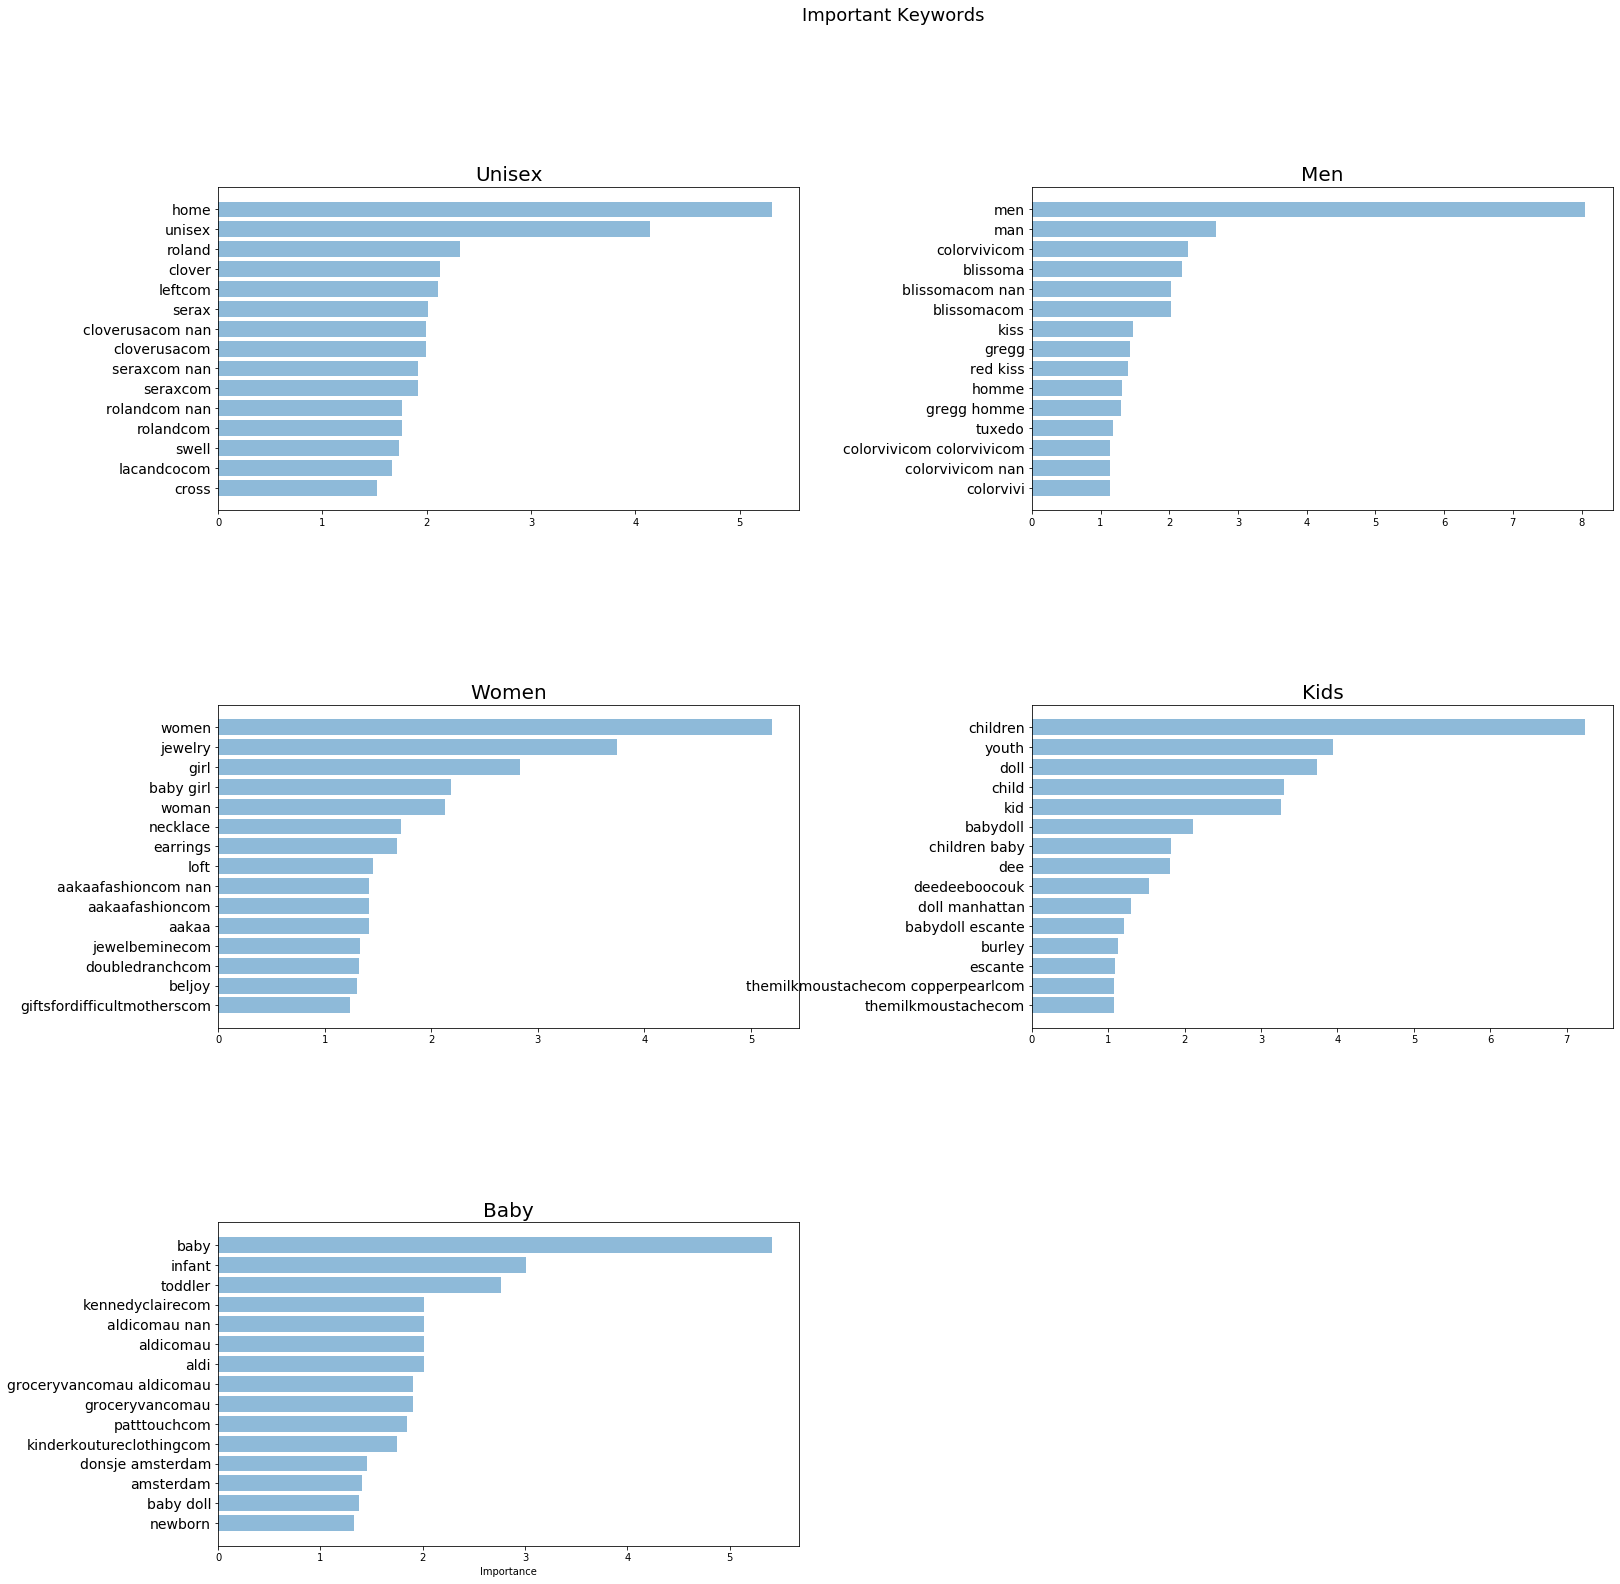

In [178]:


def plot_important_words( top_words, top_scores, label, position):

    y_pos = np.arange(len(top_words))
    plt.subplot(position)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title(label, fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)




top_scores_unisex = [a[0] for a in importance[0]['tops']]
top_words_unisex = [a[1] for a in importance[0]['tops']]

top_scores_men = [a[0] for a in importance[1]['tops']]
top_words_men = [a[1] for a in importance[1]['tops']]

top_scores_women = [a[0] for a in importance[2]['tops']]
top_words_women = [a[1] for a in importance[2]['tops']]

top_scores_kid = [a[0] for a in importance[3]['tops']]
top_words_kid = [a[1] for a in importance[3]['tops']]

top_scores_baby = [a[0] for a in importance[4]['tops']]
top_words_baby = [a[1] for a in importance[4]['tops']]

#plot_important_words(top_scores_unisex, top_words_unisex, top_scores_men, top_words_men, "Most important words")


unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]
unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]

fig = plt.figure(figsize=(25, 25))  
plot_important_words(top_words_unisex, top_scores_unisex, "Unisex", 321)   
plot_important_words(top_words_men, top_scores_men, "Men", 322)
plot_important_words(top_words_women, top_scores_women, "Women", 323)
plot_important_words(top_words_kid, top_scores_kid, "Kids", 324)
plot_important_words(top_words_baby, top_scores_baby, "Baby", 325)

plt.subplots_adjust(wspace=0.4, hspace = 0.6)
plt.suptitle("Important Keywords", fontsize=18)
plt.xlabel('Importance')
plt.show()

In [179]:
#from pivottablejs import pivot_ui
#pivot_ui(labeled_data )

## let's see how our CLF model performs on unseen data
We can use the prediction probability as a performance metric

In [180]:
unlabeled_data= df[df['class'] == '-1'].copy()

In [181]:
list_corpus = unlabeled_data["all_text"].tolist()
#list_labels = unlabeled_data["labels"].tolist()
X_test_counts = count_vectorizer.transform(list_corpus)
y_test_counts = clf.predict(X_test_counts)

# add prediction to the unlabeled_data dataframe
unlabeled_data['labels']=y_test_counts
unlabeled_data['class']=unlabeled_data['labels'].apply( classes.__getitem__)
print(X_test_counts.shape)

(440271, 132537)


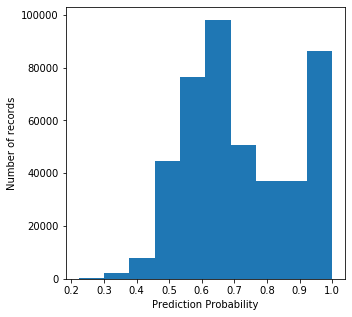

In [198]:


# add prediction probability to the unlabeled_data dataframe
unlabeled_data['probability']=cal_probability(X_test_counts)


In [184]:
confidence_threshold=0.8
high_confidence=unlabeled_data[unlabeled_data['probability']>= confidence_threshold] 
high_confidence_size=high_confidence.shape[0]
low_confidence_size=unlabeled_data.shape[0]-  high_confidence_size
print( "Number of records predicted with high confidence is {} out of {}".format( high_confidence_size, unlabeled_data.shape[0]))
print( "Number of records predicted with low confidence is {} out of {}".format( low_confidence_size, unlabeled_data.shape[0]))

Number of records predicted with high confidence is 143640 out of 440271
Number of records predicted with low confidence is 296631 out of 440271


## Let's select 40 random records and check their prediction manually

In [185]:
unisex_products=unlabeled_data[unlabeled_data['class']== 'unisex'] 
unisex_products

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,all_text,unisex,men,women,baby,kid,class,labels,probability
4,[cookware],[hestan],"[hestan, probond, forged, stainless, steel, ul...",[atlantagrillcompanycom],[hestanculinarycom],[nan],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forged, st...",cookware hestan hestan probond forged stainles...,0,0,0,0,0,unisex,0,0.481756
7,"[water, bottles]",[hestan],"[hestan, nanobond, contigo, , oz, water, bottle]",[dasallascom],[hestanculinarycom],[nan],24.95,https://dasallas.com/products/hestan-nanobond-...,Water Bottles Hestan Hestan Nanobond Contigo 2...,hestan,"[water, bottles, hestan, hestan, nanobond, con...",water bottles hestan hestan nanobond contigo ...,0,0,0,0,0,unisex,0,0.885174
15,[cookware],[hestan],"[hestan, nanobond, stainless, steel, pc, essen...",[atlantagrillcompanycom],[hestanculinarycom],[nan],799.95,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless stee...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",cookware hestan hestan nanobond stainless stee...,0,0,0,0,0,unisex,0,0.544741
18,[cookware],[hestan],"[hestan, nanobond, stainless, steel, pc, set]",[atlantagrillcompanycom],[hestanculinarycom],[nan],1599.95,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless stee...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",cookware hestan hestan nanobond stainless stee...,0,0,0,0,0,unisex,0,0.519480
56,"[diet, loss, weight]","[trace, minerals, research]","[trace, minerals, bean, extract, svetol, , gre...",[natureandherbcom],[tracemineralscom],[nan],13.18,https://natureandherb.com/products/trace-miner...,Diet and Loss Weight Trace Minerals Research T...,trace minerals research,"[diet, loss, weight, trace, minerals, research...",diet loss weight trace minerals research trace...,0,0,0,0,0,unisex,0,0.489898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499976,[parts],"[zev, technologies]","[zev, pro, curvd, trigger, bar, sml, bg]",[gunslingersarmorycom],[zevtechnologiescom],[nan],150.0,https://gunslingersarmory.com/products/zev-pro...,Parts ZEV Technologies Zev Pro Curvd Trigger B...,zev technologies,"[parts, zev, technologies, zev, pro, curvd, tr...",parts zev technologies zev pro curvd trigger b...,0,0,0,0,0,unisex,0,0.492140
499980,"[firearms, accessories]","[zev, technologies]","[zev, technologies, pro, plus, universal, magw...",[greystonetacticalcom],[zevtechnologiescom],[nan],109.0,NaN,Firearms Accessories ZEV Technologies ZEV Tech...,zev technologies,"[firearms, accessories, zev, technologies, zev...",firearms accessories zev technologies zev tech...,0,0,0,0,0,unisex,0,0.546109
499981,[parts],"[zev, technologies]","[zev, pro, flat, trig, ult, g, mm, bb]",[gunslingersarmorycom],[zevtechnologiescom],[nan],234.0,https://gunslingersarmory.com/products/zev-pro...,Parts ZEV Technologies Zev Pro Flat Trig Ult G...,zev technologies,"[parts, zev, technologies, zev, pro, flat, tri...",parts zev technologies zev pro flat trig ult g...,0,0,0,0,0,unisex,0,0.527701
499982,[parts],"[zev, technologies]","[zev, pro, trigger, bar, glk, gen, bb]",[gunslingersarmorycom],[zevtechnologiescom],[nan],129.0,https://gunslingersarmory.com/products/zev-pro...,Parts ZEV Technologies Zev Pro Trigger Bar For...,zev technologies,"[parts, zev, technologies, zev, pro, trigger, ...",parts zev technologies zev pro trigger bar glk...,0,0,0,0,0,unisex,0,0.562829


In [186]:

random_records=random.sample(unlabeled_data.index.to_list(), k=20) 
test=unlabeled_data.loc[random_records, ['class','labels','product_type','full_store_product_url' ,'all_text_original']]
display(test)
test.to_csv("../data/validate/test_random_unseen_data_LogisticReg.csv", index=True)

,class,labels,product_type,full_store_product_url,all_text_original
201851,women,2,[nan],https://tomsstylist.com/products/harry-pattern...,nan Tom's Stylist Harry Patterned Socks tomsst...
348354,women,2,"[incaltaminte, dama]",https://xoutlet.ro/products/adidasi-michael-ko...,Incaltaminte Dama MICHAEL KORS Adidasi MICHAEL...
43646,women,2,"[buttermilk, basin]",https://quiltingbookspatternsandnotions.com/pr...,Buttermilk Basin Checker Distributors Tree Ugl...
367253,women,2,[nan],https://miltacusa.com/products/team-zissou-lif...,nan MILTACUSA Team Zissou Life Aquatic Patch (...
189710,women,2,[nan],https://fromanother.ca/products/supreme-moloto...,nan From Another Supreme Sticker fromanother.c...
84440,women,2,"[mens, , mens, accessories, , womens, , womens...",https://ukcovers.co.uk/products/jockeys-and-ho...,"Mens,Mens Accessories,Womens,Womens Accessorie..."
57776,women,2,[bottoms],https://shophoneylynn.com/products/tan-midi-skirt,Bottoms Honey Lynn Boutique Tan Midi Skirt sh...
256745,women,2,[supplements],NaN,Supplements Nutrakey Nutrakey Iso Optima nutra...
438788,women,2,"[new, arrival]",https://bakerstreetonline.com/products/cargo-j...,New Arrival Baker Street Boutique Cargo Jogger...
15597,women,2,"[barcode, scanner]",https://socketstore.eu/products/s800,"Barcode Scanner Socket Store SocketScan® S800,..."


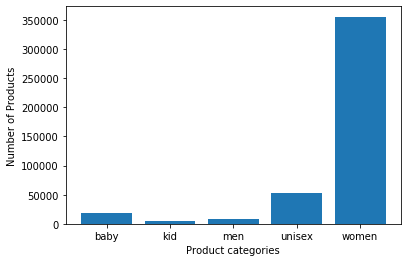

women     355655
unisex     52589
baby       18530
men         8089
kid         5408
Name: class, dtype: int64


In [187]:
plot_class_distribution (unlabeled_data, 'product_type','class', starting_index=0)
